Here's the final, mentor-approved recap neatly formatted in Markdown for your notebook or documentation:

---

## 🚗 **Saudi Arabia Used-Car Price Optimization for Syarah.com**

---

### 🎯 **SCQA: Business Framing**

**Situation:**
Sellers on syarah.com, an online used-car marketplace in Saudi Arabia, regularly list vehicles for sale. Setting the right asking price is crucial for achieving timely sales and maintaining marketplace efficiency.

**Complication:**
Many sellers inaccurately price their vehicles due to limited market insights. Overpriced cars lead to slow sales and reduced marketplace liquidity, while underpriced cars result in lost profits for sellers and lower revenues for the platform.

**Question:**
How can syarah.com help sellers reliably set optimal asking prices to minimize pricing errors, accelerate sales, and improve both seller profitability and overall marketplace performance?

**Answer:**
Develop and deploy a robust machine-learning model that predicts accurate market-aligned prices for used cars, significantly reducing pricing errors. This will increase marketplace liquidity, accelerate sales, and maximize profit for both sellers and syarah.com.

---

### 📊 **Metrics & Evaluation**

**Primary Metric:**

* **Mean Absolute Error (MAE)** in Saudi Riyals (SAR)

  * Clear interpretation: "On average, our model is accurate within ±2,800 SAR."
  * Symmetric penalty for both overpriced and underpriced listings.
  * Robust against extreme high-price outliers.

**Companion Metric:**

* **Median Absolute Percentage Error (MdAPE)**

  * Provides fairness across different price ranges.
  * Offers clear interpretability: "Half our predictions fall within ±X% of actual prices."

**Business Impact Evaluation:**

* Based on model accuracy (\~5% MAE), assume predicted prices closely represent "true market value."
* Classify listings as:

  * **Overpriced:** Actual price > 5% above model prediction.
  * **Underpriced:** Actual price > 5% below model prediction.
  * **Well-priced:** Within ±5% range.
* Quantify business impact using:

  * **Underpriced cars:** Calculate potential profit recovered (price gap).
  * **Overpriced cars:** Estimate faster sale (e.g., assume 1 selling day saved per 2% price correction).

---

### 🤖 **Final Model & Benchmark Plan**

**Baseline Model:**

* **ElasticNet linear regression** (interpretable and simple)

  * Expected MAE ≈ 6,700 SAR.

**Final Selected Model:**

* ✅ **CatBoost Regressor**

  * Handles categorical variables natively (no need for extensive encoding).
  * Provides built-in interpretability (SHAP values).
  * Expected MAE ≈ 2,800 SAR (≈5% of average car price).

**Additional Comparison Models (Optional):**

* ✅ **XGBoost / LightGBM**

  * For validation, robustness, or slight performance gains.

---

### 🔍 **Data Preparation & Feature Engineering**

**Data Handling:**

* Remove listings marked as "Negotiable" (`Price = 0`)—mentor-confirmed safe.
* Light-touch outlier treatment (top 1% or ±3σ only) to match hidden test conditions.

**Feature Engineering (Minimal, business-relevant):**

* `CarAge = 2025 - Year`
* Raw categorical features (`Make`, `Type`, `Region`, `Gear_Type`, `Options`) for CatBoost.

---

### 📉 **Model Interpretability**

* Utilize **SHAP plots** (from CatBoost) to visually communicate feature importance to stakeholders.
* Identify clear business insights (key pricing factors like Age, Mileage, Brand).

---

### 📈 **Deployment Scenario (Hypothetical)**

* Model integrated directly into syarah.com’s user interface.
* Sellers receive immediate, accurate price recommendations upon listing cars.
* Marketplace moderators leverage predictions to identify and flag mispriced listings.

---

### 🧪 **Final Evaluation Plan**

* Perform cross-validation (80/20 split, random or grouped by `Make`).
* Evaluate and report metrics:

  * MAE (primary) and MdAPE (companion).
* Calculate and clearly present business impact (money saved, sales accelerated).

---

### 🚩 **Final Project Summary Table**

| Aspect               | Final Decision                                                          |
| -------------------- | ----------------------------------------------------------------------- |
| **Stakeholder/User** | Hypothetical used-car marketplace (syarah.com)                          |
| **Primary Metric**   | Mean Absolute Error (MAE) in SAR (\~2,800 target, \~5% of avg price)    |
| **Companion Metric** | Median Absolute Percentage Error (MdAPE)                                |
| **Benchmark Model**  | ElasticNet linear regression (\~6,700 SAR MAE)                          |
| **Final Model**      | CatBoost Regressor (\~2,800 SAR MAE)                                    |
| **Optional Models**  | XGBoost, LightGBM                                                       |
| **Data Handling**    | Drop Negotiable prices, minimal outlier removal (top 1% or ±3σ)         |
| **Business Impact**  | ±5% threshold for mispricing: calculate profit recovered & faster sales |
| **Interpretability** | SHAP values (built-in CatBoost)                                         |

---

### ✨ **Concise One-Liner Project Narrative**

> "**We built a CatBoost model to help syarah.com accurately price used cars, significantly reducing typical seller mispricing errors, saving thousands of Riyals per car, accelerating marketplace sales, and enhancing overall platform performance.**"

---

1. Normally, when the dataset has no missing data, do we still put in imputers in the model just in case the new real-world data has some missing data?
2. What if the test set has a negotiable price in it? That would ruin my model performance especially if I decide to drop the negotiable rows as I do not have control over the test dataset
3. Is choosing boosting methods like CatBoost or XGBoost and further Ensemble Methods fine? Or is it too much for a task like this and better to go for simpler models like multiple linear regression?

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data_saudi_used_cars.csv')
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


In [4]:
df.describe(include='all')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


In [5]:
df.isna().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [6]:
df.duplicated().sum()

4

In [7]:
df[df.duplicated(keep=False)]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
236,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910
540,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000
953,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000
2012,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000
3631,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0
4646,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910
4933,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000
5267,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0


In [8]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5620 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5620 non-null   object 
 1   Region       5620 non-null   object 
 2   Make         5620 non-null   object 
 3   Gear_Type    5620 non-null   object 
 4   Origin       5620 non-null   object 
 5   Options      5620 non-null   object 
 6   Year         5620 non-null   int64  
 7   Engine_Size  5620 non-null   float64
 8   Mileage      5620 non-null   int64  
 9   Negotiable   5620 non-null   bool   
 10  Price        5620 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 488.5+ KB


In [9]:
df['Type'].value_counts()

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64

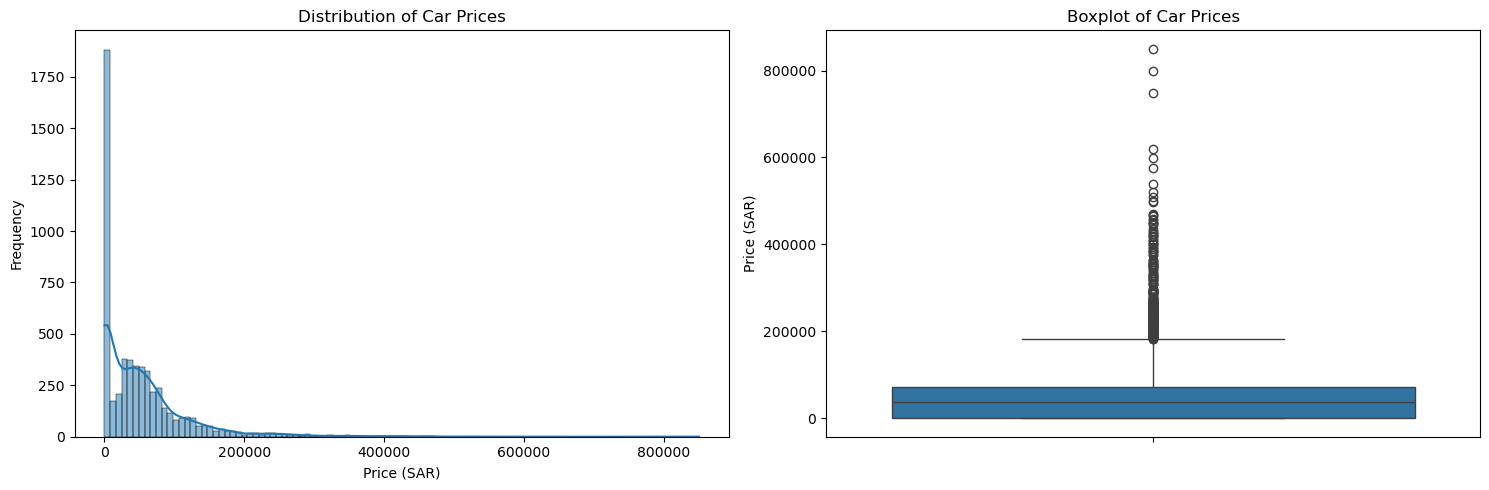

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram with KDE
sns.histplot(df['Price'], kde=True, ax=ax1)
ax1.set_title('Distribution of Car Prices')
ax1.set_xlabel('Price (SAR)')
ax1.set_ylabel('Frequency')

# Plot boxplot
sns.boxplot(y=df['Price'], ax=ax2)
ax2.set_title('Boxplot of Car Prices')
ax2.set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()

In [11]:
# Calculate IQR for Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

# Count outliers and calculate percentage
outlier_count = len(outliers)
outlier_percentage = (outlier_count / len(df)) * 100

print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Display statistics of outliers
print("\nStatistics of outliers:")
print(outliers['Price'].describe())

Number of outliers: 261
Percentage of outliers: 4.64%
Lower bound: -109500.00
Upper bound: 182500.00

Statistics of outliers:
count       261.000000
mean     284848.275862
std      102655.374765
min      183000.000000
25%      220000.000000
50%      251500.000000
75%      325000.000000
max      850000.000000
Name: Price, dtype: float64


### Test after removing Negotiable prices

In [12]:
# Calculate the number of rows with Negotiable as True
negotiable_true_count = df['Negotiable'].sum()

# Calculate the percentage
negotiable_true_percentage = (negotiable_true_count / len(df)) * 100

print(f"Number of cars with Negotiable=True: {negotiable_true_count}")
print(f"Percentage of cars with Negotiable=True: {negotiable_true_percentage:.2f}%")

# Check how many of these have Price = 0
negotiable_zero_price = df[(df['Negotiable'] == True) & (df['Price'] == 0)]
print(f"\nNumber of negotiable cars with Price=0: {len(negotiable_zero_price)}")
print(f"Percentage of negotiable cars with Price=0: {(len(negotiable_zero_price) / negotiable_true_count) * 100:.2f}%")

Number of cars with Negotiable=True: 1795
Percentage of cars with Negotiable=True: 31.94%

Number of negotiable cars with Price=0: 1795
Percentage of negotiable cars with Price=0: 100.00%


In [13]:
df_filtered = df[df['Price'] > 0]

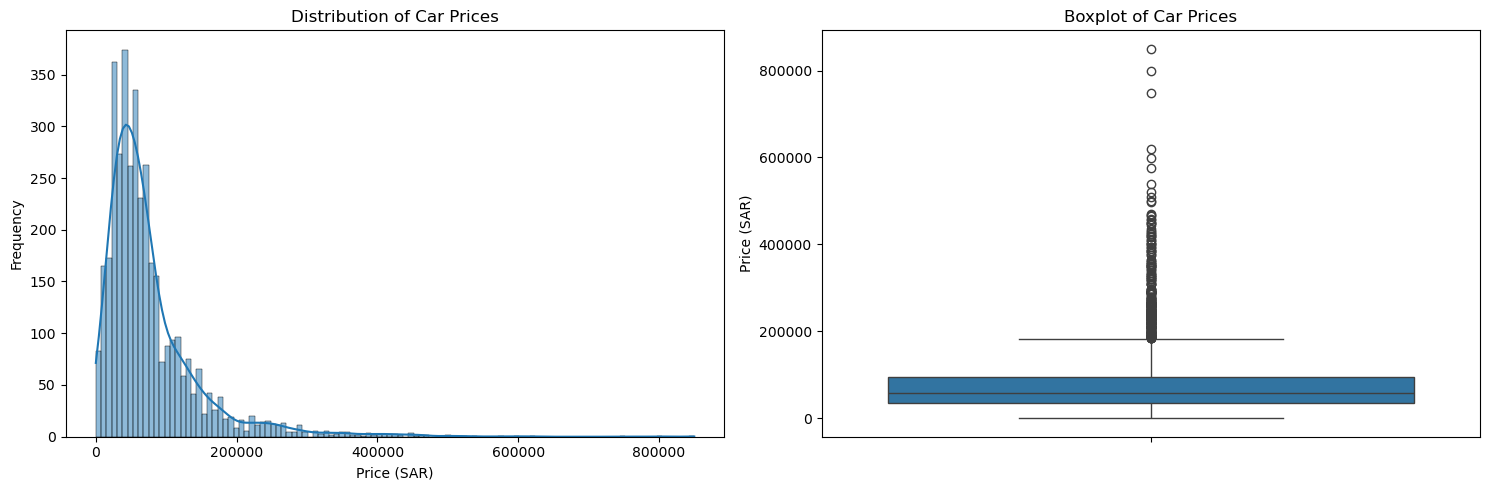

In [14]:
# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram with KDE
sns.histplot(df_filtered['Price'], kde=True, ax=ax1)
ax1.set_title('Distribution of Car Prices')
ax1.set_xlabel('Price (SAR)')
ax1.set_ylabel('Frequency')

# Plot boxplot
sns.boxplot(y=df_filtered['Price'], ax=ax2)
ax2.set_title('Boxplot of Car Prices')
ax2.set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()

In [15]:
# Calculate IQR for Price
Q1 = df_filtered['Price'].quantile(0.25)
Q3 = df_filtered['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values below (Q1 - 1.5*IQR) or above (Q3 + 1.5*IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_filtered[(df_filtered['Price'] < lower_bound) | (df_filtered['Price'] > upper_bound)]

# Count outliers and calculate percentage
outlier_count = len(outliers)
outlier_percentage = (outlier_count / len(df_filtered)) * 100

print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Display statistics of outliers
print("\nStatistics of outliers:")
print(outliers['Price'].describe())

Number of outliers: 259
Percentage of outliers: 6.77%
Lower bound: -53875.00
Upper bound: 183125.00

Statistics of outliers:
count       259.000000
mean     285634.749035
std      102658.582321
min      185000.000000
25%      220000.000000
50%      252000.000000
75%      325000.000000
max      850000.000000
Name: Price, dtype: float64
